In [1]:
"""
PRIA version
Additive white Gaussian noise (AWGN)
"""
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
import os
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np


In [2]:
def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """
    # 需要進行 normalization，否則 binary_crossentropy loss 為負數
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array

def noise(array, noise_factor):
    """
    Adds random noise to each image in the supplied array.
    """

    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

# 第一組原圖, 第四組加了較多量雜訊的圖

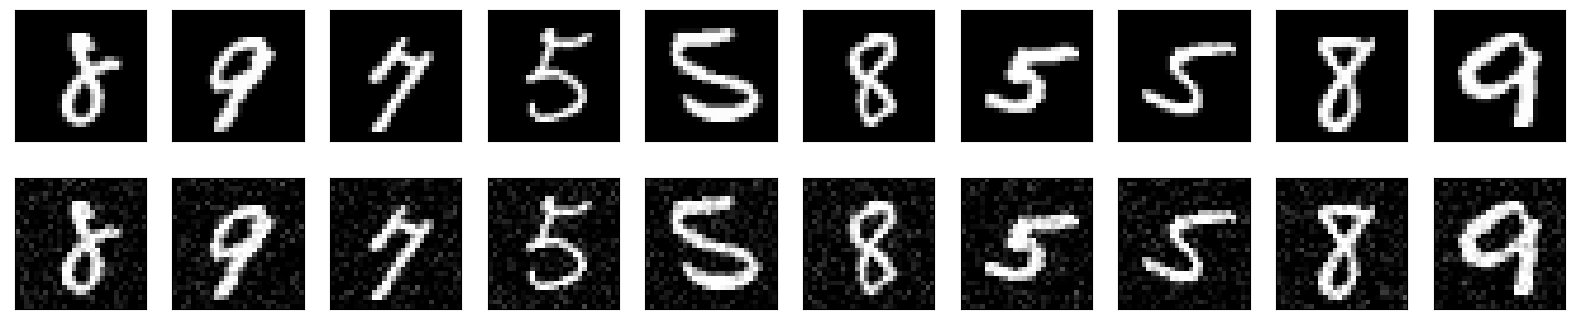

In [4]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data, noise_factor=0.1)
noisy_test_data = noise(test_data, noise_factor=0.1)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

In [5]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
# 1x28x28
# Encoder 使用卷積層，激活函數用 relu，輸入的維度就是上面定義的 input_img
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
# 16@28x28
x = MaxPooling2D((2, 2), padding='same')(x)
# 16@14x14
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# 8@14X14
encoded = MaxPooling2D((2, 2), padding='same', name='encoder')(x)
# 8@7x7    
    
# Decoder 的過程與 Encoder 正好相反，需要跟 Encoder 的神經網絡層做相對應，相對應的激活函數也是一樣，
# 但這邊在解碼中最後一層使用的激活函數是 sigmoid
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
# 8@7x7    
x = UpSampling2D((2, 2))(x)
# 8@14X14
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
# 16@14X14
x = UpSampling2D((2, 2))(x)
# 16@28x28
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='decoder')(x)

    
# 用 Model 來搭建模型，輸入為圖片，輸出是解碼的結果
autoencoder = Model(input_img, decoded)  
    
# 編譯模型，optimizer 使用 adam，loss 使用 binary_crossentropy
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 encoder (MaxPooling2D)      (None, 7, 7, 8)           0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584       
                                                             

In [6]:
# 訓練 Denoising AE
# This will train for 20 epochs
autoencoder.fit(noisy_train_data, train_data, epochs=20, batch_size=128, 
                shuffle=True, validation_data=(noisy_test_data, test_data), 
                callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/tb', histogram_freq=0, write_graph=False)])

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
469/469 [==============================] - ETA: 0s - loss: 0.7064WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000014E802009D8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the fu

# 第四組加了較多量雜訊的圖, 第五組去完雜訊的圖

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


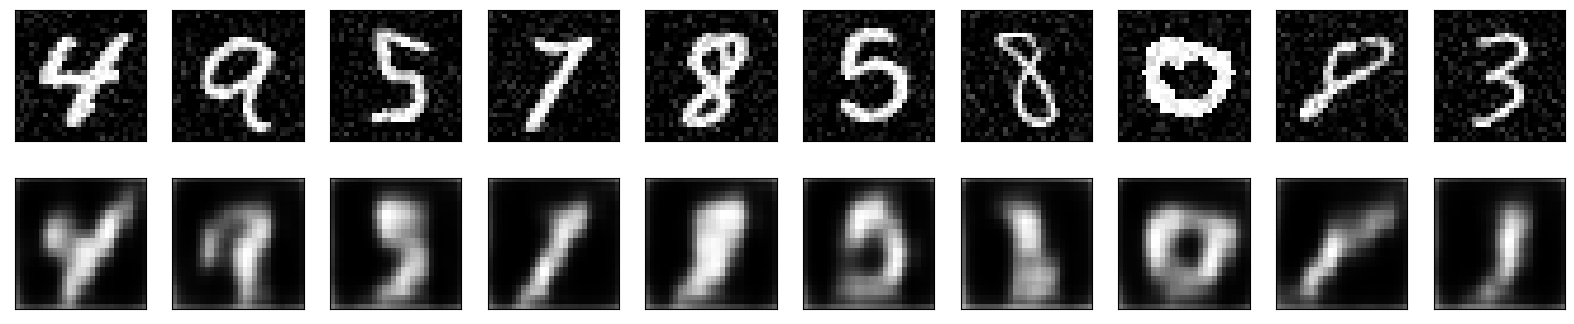

In [7]:
predictions = autoencoder.predict(train_data)
display(noisy_train_data, predictions)

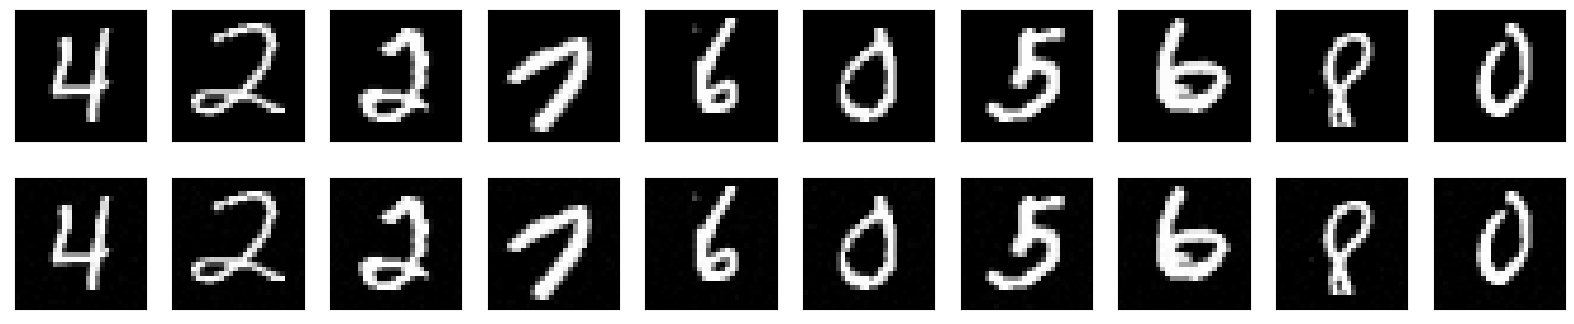

In [8]:
# Create a copy of the data with added noise
noisy_train_data = noise(train_data, noise_factor=0.01)
noisy_test_data = noise(test_data, noise_factor=0.01)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

In [9]:
# 訓練 Denoising AE
# This will train for 20 epochs
autoencoder.fit(noisy_train_data, train_data, epochs=20, batch_size=128, 
                shuffle=True, validation_data=(noisy_test_data, test_data), 
                callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/tb', histogram_freq=0, write_graph=False)])

Epoch 1/20
469/469 [==============================] - 46s 97ms/step - loss: 0.2133 - val_loss: 0.2080
Epoch 2/20
469/469 [==============================] - 46s 99ms/step - loss: 0.2043 - val_loss: 0.2001
Epoch 3/20
469/469 [==============================] - 46s 97ms/step - loss: 0.1974 - val_loss: 0.1938
Epoch 4/20
469/469 [==============================] - 45s 97ms/step - loss: 0.1917 - val_loss: 0.1886
Epoch 5/20
469/469 [==============================] - 47s 101ms/step - loss: 0.1868 - val_loss: 0.1840
Epoch 6/20
469/469 [==============================] - 46s 98ms/step - loss: 0.1827 - val_loss: 0.1801
Epoch 7/20
469/469 [==============================] - 45s 96ms/step - loss: 0.1790 - val_loss: 0.1767
Epoch 8/20
469/469 [==============================] - 47s 100ms/step - loss: 0.1758 - val_loss: 0.1736
Epoch 9/20
469/469 [==============================] - 47s 100ms/step - loss: 0.1729 - val_loss: 0.1709
Epoch 10/20
469/469 [==============================] - 45s 95ms/step - loss: 0.

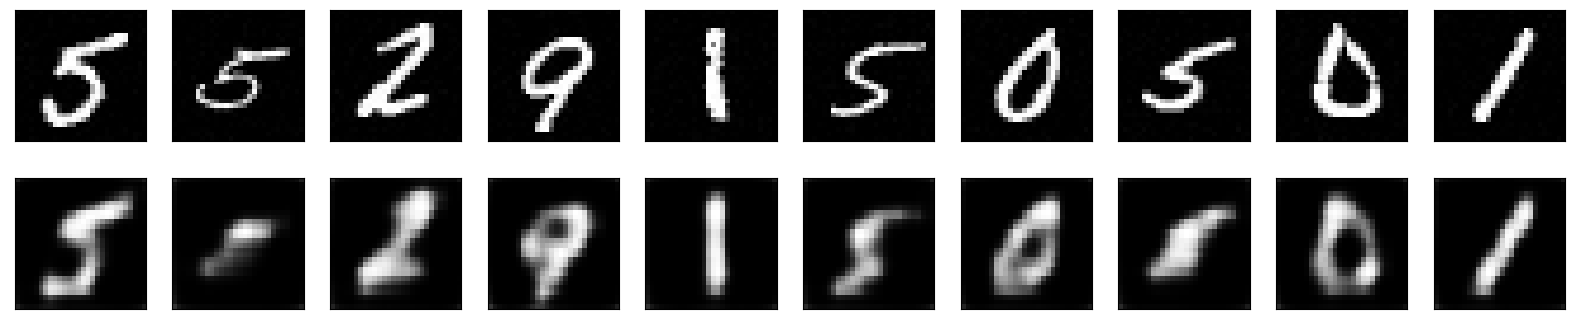

In [10]:
predictions = autoencoder.predict(train_data)
display(noisy_train_data, predictions)